<a href="https://colab.research.google.com/github/love-bees/my-notebooks/blob/master/linreg_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First way (using sklearn)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

In [2]:
data = pd.read_excel('Regression.xlsx')

In [3]:
data.head(5)

,LST,NDVI
0,0.223036,42.519179
1,0.201979,42.617420
2,0.284411,41.965477
3,0.270442,41.966960
4,0.270002,43.105206


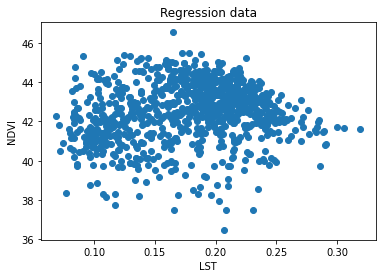

In [4]:
X = data['LST'].values
y = data['NDVI'].values

plt.scatter(X,y)
plt.xlabel('LST');
plt.ylabel('NDVI');
plt.title('Regression data');

#the linear trend isn't obvious from the plot

In [5]:
model = LinearRegression()

In [6]:
model.fit(X[:,np.newaxis], y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7]:
xfit = np.linspace(0.07, 0.3, 1000)
yfit = model.predict(xfit[:,np.newaxis])

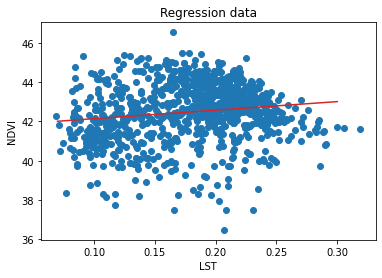

In [8]:
plt.scatter(X, y)
plt.plot(xfit, yfit, 'C3');
plt.xlabel('LST');
plt.ylabel('NDVI');
plt.title('Regression data');

# Second way (using tensorflow)

In [9]:
X = X.reshape(X.shape[0],1)

In [10]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

train_features , test_features ,train_labels, test_labels = train_test_split(X, y, test_size = 0.2)

train_X = tf.constant( train_features , dtype=tf.float32 )
train_Y = tf.constant( train_labels , dtype=tf.float32 )

test_X = tf.constant( test_features , dtype=tf.float32 )
test_Y = tf.constant( test_labels , dtype=tf.float32 )

In [11]:
#defining the mean square error, it's derivative and the hypothesis function

def MSE(Y,y_pred):
    return tf.reduce_mean(tf.square(y_pred-Y))

def MSE_derivative(Y,y_pred):
    return tf.reshape(tf.reduce_mean(2*(y_pred - Y)), [1, 1])

def h(X,weights,bias):
    return tf.tensordot(X, weights, axes=1)+bias

In [12]:
#generating data for learning and shuffling the dataset
num_epochs = 100
num_samples = train_X.shape[0]
batch_size = 10
learning_rate = 0.001

dataset = tf.data.Dataset.from_tensor_slices((train_X , train_Y))
dataset = dataset.shuffle( 500 ).repeat( num_epochs ).batch( batch_size )
iterator = dataset.__iter__()

In [13]:
#generating number of features, a random weight and setting the starting bias to 0
num_features = train_X.shape[1]
weights = tf.random.normal((num_features, 1))
bias = tf.random.normal((num_features, 1))

#will be used for plotting after
epochs_plot = list()
loss_plot = list()

for i in range(num_epochs) :

    epoch_loss = list()
    for j in range(int(num_samples/batch_size)):

        x_batch , y_batch = iterator.get_next()

        output = h(x_batch, weights, bias)
        loss = epoch_loss.append( MSE( y_batch , output ).numpy() )

        dJ_dH = MSE_derivative(y_batch, output)
        dH_dW = x_batch
        dJ_dW = tf.reduce_mean( dJ_dH * dH_dW )
        dJ_dB = tf.reduce_mean( dJ_dH )

        weights -= (learning_rate * dJ_dW)
        bias -= (learning_rate * dJ_dB)
    loss = np.array(epoch_loss).mean()
    epochs_plot.append(i + 1)
    loss_plot.append(loss)

    #print('Loss is', loss )

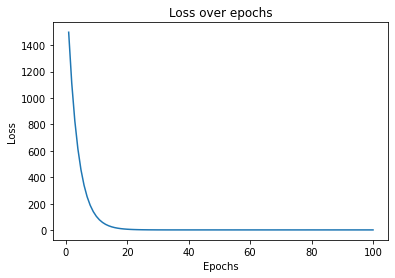

In [14]:
plt.plot(epochs_plot, loss_plot)
plt.title('Loss over epochs');
plt.xlabel('Epochs');
plt.ylabel('Loss');

In [15]:
output = h(test_X , weights , bias )
labels = test_Y

accuracy_op = tf.metrics.MeanAbsoluteError()
accuracy_op.update_state( labels , output )
print( 'Mean Absolute Error = {}'.format( accuracy_op.result().numpy() ) )

Mean Absolute Error = 1.2001014947891235


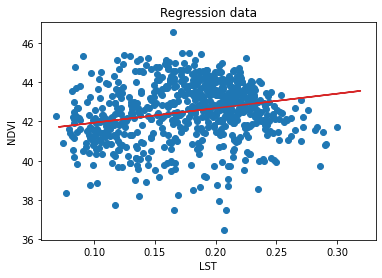

In [16]:
plt.scatter(train_X,train_Y)
plt.plot(test_X, output, color='C3')
plt.xlabel('LST');
plt.ylabel('NDVI');
plt.title('Regression data');